# Classification of Heart Disease Using K-Nearest Neighbor

## Introduction
- Literature Review: background info on heart disease
- Research Questions
- About the Dataset used

Many people die of cardiovascular diseases without knowing they have a problem with their heart. Unexpected deaths as such can be prevented with early diagnoses of cardiovascular issues and proper medication. How can the presence of heart diseases be detected in patients? The heart disease data set we are using contains 14 attributes collected from Cleveland and is still used my ML researchers to this day.  

## Preliminary Exploratory Data Analysis
#### 1. Download and Read the dataset from the web (use URL)

In [39]:
# Call packages that will be used.
library(tidyverse)
library(tidymodels)

In [18]:
# Set the value of seed to ensure reproducibility
set.seed(200)

In [19]:
# To download the dataset from the web
url <- 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
download.file(url,destfile='Data/HeartDisease_Cleveland.csv')

In [35]:
# Read the 'HeartDisease_Cleveland.csv' file into a dataframe
heart_cleve <- read_csv('Data/HeartDisease_Cleveland.csv',col_names=FALSE)
head(heart_cleve)

Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_double(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double(),
  X10 = col_double(),
  X11 = col_double(),
  X12 = col_character(),
  X13 = col_character(),
  X14 = col_double()
)



X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


#### 2. Clean and Wrangle data into tidy format

In [41]:
# Clean and Wrangle the data into tidy format
heart_cleve <- rename(heart_cleve, age = X1,
               sex = X2,
               cp = X3,
               trestbps = X4,
               chol = X5,
               fbs = X6,
               restecg = X7,
               thalach = X8,
               exang = X9,
               oldpeak = X10,
               slope = X11,
               ca = X12,
               thal = X13,
               num = X14) %>% 
            mutate(num = as_factor(num),ca = as.numeric(ca),thal = as.numeric(ca))
head(heart_cleve)

Warning message:
“Problem with `mutate()` input `ca`.
ℹ NAs introduced by coercion
ℹ Input `ca` is `as.numeric(ca)`.”
Warning message in mask$eval_all_mutate(dots[[i]]):
“NAs introduced by coercion”


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,0,0
67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
67,1,4,120,229,0,2,129,1,2.6,2,2,2,1
37,1,3,130,250,0,0,187,0,3.5,3,0,0,0
41,0,2,130,204,0,2,172,0,1.4,1,0,0,0
56,1,2,120,236,0,0,178,0,0.8,1,0,0,0


#### 4. Summary statistics about the training data (use tables)

In [42]:
# Split the dataset into training and test sets

heart_split <- initial_split(heart_cleve,prop=0.75,strata=num)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

In [88]:
# Summary Statistics about the training data

# number of observations in each class
heart_sum_class <- heart_train %>% 
                group_by(num) %>%
                summarise(n=n())
heart_sum

`summarise()` ungrouping output (override with `.groups` argument)



num,n
<fct>,<int>
0,123
1,42
2,26
3,26
4,12


In [98]:
# means of predictor variables used in analysis
heart_mean <- heart_train%>% 
                    select(-num) %>%
                    map_df(mean,na.rm = TRUE)
heart_min <- heart_train %>%
                    select(-num) %>%
                    map_df(min,na.rm=TRUE)
heart_max <- heart_train %>%
                    select(-num) %>%
                    map_df(max,na.rm=TRUE)
heart_median <- heart_train %>%
                    select(-num) %>%
                    map_df(median,na.rm=TRUE)

heart_sum_pred <- rbind(heart_min,heart_median,heart_mean,heart_max) %>%
                    mutate(Statistics=c('Min','Median','Mean','Max'),.before=age)
heart_sum_pred

Statistics,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Min,29.00000,0.0000000,1.00000,94.0000,126.000,0.0000000,0.0000000,71.0000,0.0000000,0.00000,1.000000,0.0000000,0.0000000
Median,56.00000,1.0000000,3.00000,130.0000,244.000,0.0000000,0.0000000,153.0000,0.0000000,0.80000,2.000000,0.0000000,0.0000000
Mean,55.12227,0.6812227,3.19214,131.9694,249.917,0.1310044,0.9825328,149.0699,0.3144105,1.00262,1.611354,0.7048458,0.7048458
Max,77.00000,1.0000000,4.00000,200.0000,564.000,1.0000000,2.0000000,202.0000,1.0000000,4.40000,3.000000,3.0000000,3.0000000


In [95]:
# number of rows with missing data
any(is.na(heart_train[12]))

heart_missing <-0
for (n in 1: nrow(heart_train)) {
    if (any(is.na(slice(heart_train,n)))==TRUE) {
        heart_missing <- heart_missing +1 }
        }

heart_missing

[1] 2

In [80]:
summary(heart_train)

      age             sex               cp           trestbps        chol      
 Min.   :29.00   Min.   :0.0000   Min.   :1.000   Min.   : 94   Min.   :126.0  
 1st Qu.:49.00   1st Qu.:0.0000   1st Qu.:3.000   1st Qu.:120   1st Qu.:212.0  
 Median :56.00   Median :1.0000   Median :3.000   Median :130   Median :244.0  
 Mean   :55.12   Mean   :0.6812   Mean   :3.192   Mean   :132   Mean   :249.9  
 3rd Qu.:62.00   3rd Qu.:1.0000   3rd Qu.:4.000   3rd Qu.:140   3rd Qu.:282.0  
 Max.   :77.00   Max.   :1.0000   Max.   :4.000   Max.   :200   Max.   :564.0  
                                                                               
      fbs           restecg          thalach          exang       
 Min.   :0.000   Min.   :0.0000   Min.   : 71.0   Min.   :0.0000  
 1st Qu.:0.000   1st Qu.:0.0000   1st Qu.:132.0   1st Qu.:0.0000  
 Median :0.000   Median :0.0000   Median :153.0   Median :0.0000  
 Mean   :0.131   Mean   :0.9825   Mean   :149.1   Mean   :0.3144  
 3rd Qu.:0.000   3rd Qu.:

#### 4. Visualize the training data (use plots)
    - compare the distributions of each of the predictor variables used in the analysis

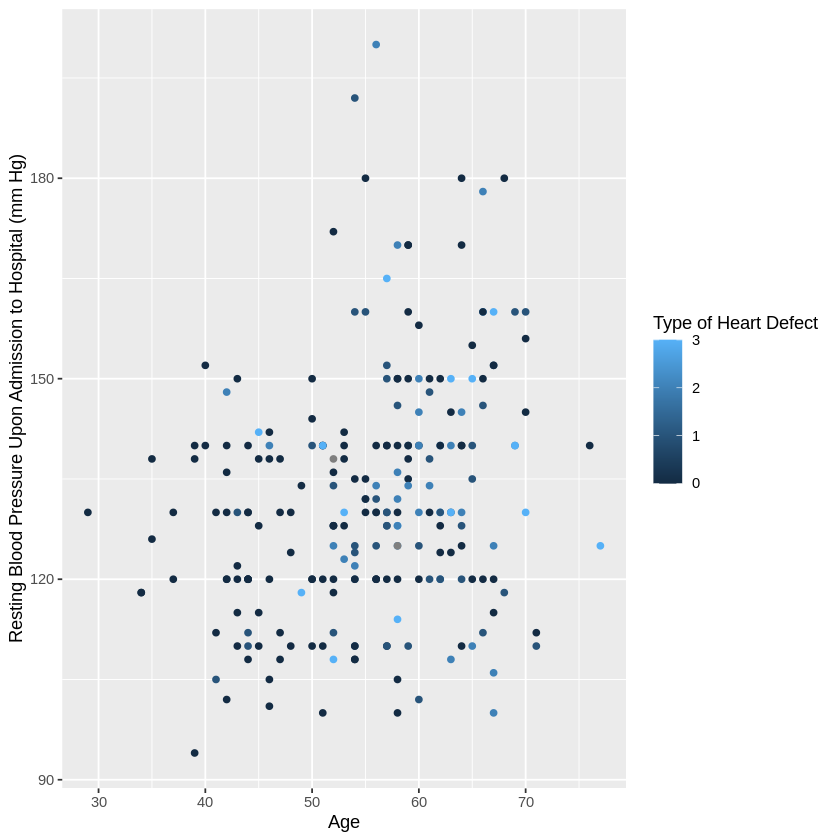

In [105]:
op
heart_plot <- heart_train %>%
ggplot(aes(x=age, y=trestbps, colour = thal)) +
geom_point() +
labs(x = "Age", y = "Resting Blood Pressure Upon Admission to Hospital (mm Hg)", colour = "Type of Heart Defect") 

heart_plot

## Methods
- Explain how to conduct the data analysis
- Explain which variables you will use
- Describe at least one way you will visualize the results

## Expected Outcomes and Significance
- What do you expect to find?
- What impact could such findings have?
- What future questions could this lead to?